In [1]:
import pandas as pd 
import numpy as np 
import pathlib as path
import matplotlib.pyplot as plt
import random
from PIL import Image
from random import sample

In [2]:
#this is where all downladed data exists (after extracting the zip file)
#PATH_TO_DATA = path.Path(r'C:\Users\User\Desktop\visualpilot')

PATH_TO_DATA = path.Path.cwd().parent / 'data' #true relational path

#this will define the name of the location to save the processed csv files (note that it will also create a "batch" directory)
batch_name='batch7' #defines the name of the current subfolder to work on

processed_name='processed data' + batch_name[-1]
PATH_TO_PROCESSED = PATH_TO_DATA / processed_name

if not(PATH_TO_PROCESSED.exists()):
    print('creating a new processed folder:',PATH_TO_PROCESSED)
    PATH_TO_PROCESSED.mkdir()
else:
    print('allready exists:',PATH_TO_PROCESSED)


creating a new processed folder: c:\Users\User\Desktop\visualpilot2\Visual-memory-task\data\processed data7


In [3]:
PATH_TO_BATCH=PATH_TO_DATA / batch_name
AMAZON_WORKER_fILE_PATH= PATH_TO_DATA / path.Path(batch_name+'_batch_results.csv')

batch_workers_df=pd.read_csv(AMAZON_WORKER_fILE_PATH)
print('number of amazon workers as reported from the amazon workers file : ',len(batch_workers_df))

#check how many participants are in the downloaded folder: 
participants_list_csvs=[file.name for file in PATH_TO_BATCH.iterdir() if '.csv' in file.name and file.stat().st_size>10000]
participants_list_names=[file.split('_')[0] for file in participants_list_csvs]
print(f'number of participant files (of sufficient size) in the downloaded results batch: {len(participants_list_csvs)}')
print(f'number of unique participant names in the batch: {len(set(participants_list_names))}')
#solve the non unique participants:
non_unique_names=np.unique([name for name in participants_list_names if participants_list_names.count(name)>1])

if len(non_unique_names)>0:
   print(f'\nhandling duplicate participants {len(non_unique_names)}:')
   #find the most recent/biggest file size from each non unique participant: 
   for participant in non_unique_names:
      all_curr_participant_csv_names=list(np.array(participants_list_csvs)[np.where(np.array(participants_list_names)==participant)])
      #get the system info on each of these duplicate files: 
      filesizes=[(PATH_TO_BATCH / file).stat().st_size for file in all_curr_participant_csv_names]
      filedates=[(PATH_TO_BATCH / file).stat().st_ctime for file in all_curr_participant_csv_names]
      largest_filesize_ind=np.argmax(filesizes) #get the index of the largest file from the duplicates
      latest_filedate_ind=np.argmax(filedates)  #get the index of the latest file from the duplicates
      if largest_filesize_ind==latest_filedate_ind: #if the same size is the most recent and largest use it as the participant file: 
         print(f'{participant} has {len(all_curr_participant_csv_names)} duplicate files  - taking the largest and latest file for this participant')
         valid_csv=all_curr_participant_csv_names[largest_filesize_ind]
         #remove it from the current subject duplicates list: 
         all_curr_participant_csv_names.remove(valid_csv)
         #remove the other duplicates fromt he participanst_list_csv: 
         for csv_to_remove in all_curr_participant_csv_names:
            participants_list_csvs.remove(csv_to_remove)
      else:
         print(f'{participant} has {len(all_curr_participant_csv_names)} duplicate files  the largest file is not the latest, so need to resolve this conflict manualy')

#get the aligned names vector after removing the duplicates: 
participants_list_names=[file.split('_')[0] for file in participants_list_csvs]
print(f'\nafter removing duplicate files, number of valid participant files = {len(participants_list_names)}\n')


#make sure the participants reported in the amazon workers corresponds to the valid csv files we got: 
print('going over the workers list as reported in amazon and finding a valid csv file for each')
valid_participants_files=[]
valid_participants_names=[]
for cur_participant in batch_workers_df['WorkerId'].values:
    if cur_participant in participants_list_names: 
      #update the batch workers file with the relevant csv name and validation columns
      batch_workers_df.loc[batch_workers_df['WorkerId']==cur_participant,'csv_path']=participants_list_csvs[participants_list_names.index(cur_participant)]
      batch_workers_df.loc[batch_workers_df['WorkerId']==cur_participant,'Approve']='x'
      #print(cur_participant)'
      valid_participants_files.append(participants_list_csvs[participants_list_names.index(cur_participant)]) 
      valid_participants_names.append(cur_participant)
    else:
      print('invalid',cur_participant)
      batch_workers_df.loc[batch_workers_df['WorkerId']==cur_participant,'Reject']='no results file was found on pavlovia servers'
    
print(f'number of valid participants to go to further processing is: {len(valid_participants_files)}')     
    

number of amazon workers as reported from the amazon workers file :  35
number of participant files (of sufficient size) in the downloaded results batch: 25
number of unique participant names in the batch: 25

after removing duplicate files, number of valid participant files = 25

going over the workers list as reported in amazon and finding a valid csv file for each
invalid A35D8WIV6CP70I
invalid A2N5CZXY8IGBHP
invalid A2CK5XYQ3LX0RP
invalid A2WSNXVA7LQYSG
invalid A30FRPL9798W4Q
invalid A39D0EVFM2ZQNA
invalid A33B9RCIJ7DRGS
invalid AS9RZL1B7D9FB
invalid A2GOMJYR58XO5H
invalid A39TAEDYNFN1SS
number of valid participants to go to further processing is: 25


In [4]:
batch_workers_df[['WorkerId','Approve','Reject','Answer.surveycode','csv_path']] #will add more columns with more information on disqualfication so we can decide if we pay or not

,WorkerId,Approve,Reject,Answer.surveycode,csv_path
0,AOQP9IL4MK3ZQ,x,NaN,tjs,AOQP9IL4MK3ZQ_2022-10-19_06h59.20.459.csv
1,A35D8WIV6CP70I,NaN,no results file was found on pavlovia servers,'tjs',NaN
2,ACUK17I51KVXF,x,NaN,tjs,ACUK17I51KVXF_2022-10-19_10h23.23.440.csv
3,A96TDNBSXG3NJ,x,NaN,tjs,A96TDNBSXG3NJ_2022-10-19_07h41.25.219.csv
4,AW9ODYOD9PYHX,x,NaN,tjs,AW9ODYOD9PYHX_2022-10-19_07h13.52.846.csv
5,A2N5CZXY8IGBHP,NaN,no results file was found on pavlovia servers,'tjs',NaN
6,A1SHLWKA0UH1IS,x,NaN,tjs,A1SHLWKA0UH1IS_2022-10-19_08h12.50.994.csv
7,A2CK5XYQ3LX0RP,NaN,no results file was found on pavlovia servers,tjs,NaN
8,A1LG7I4UFRWZRY,x,NaN,tjs,A1LG7I4UFRWZRY_2022-10-19_08h35.08.314.csv
9,A2WSNXVA7LQYSG,NaN,no results file was found on pavlovia servers,"""tjs""",NaN


In [5]:
def find_largest_consequtive_repetition(responses_array):
#add a stop value so the loop will use the logic also if the end of the responses is all repeating: 
    responses_array=np.append(responses_array,[99])
    longest_rep_dict=dict()
    last_input=responses_array[0]
    consequtive_rep_counter=0
    for response in responses_array[1:]: 
        if response==last_input: #if consequtive rep: 
            consequtive_rep_counter=consequtive_rep_counter+1 #add to counter
        else: #once a new entry is in the vector - store the counter rep information 
            if last_input in longest_rep_dict.keys(): #if it was allready stored in our dictionary
                if longest_rep_dict[last_input]<consequtive_rep_counter: #replace the counter only if it is higher than what stored in dict
                    longest_rep_dict[last_input]=consequtive_rep_counter
            else: #this entry is not yet in the dictionary: add it 
                longest_rep_dict[last_input]=consequtive_rep_counter
            
            consequtive_rep_counter=0
            last_input=response
    return max(longest_rep_dict.values())

In [6]:
def process_worker_results(PATH_TO_BATCH,subject_name):
    cur_sub=pd.read_csv(PATH_TO_BATCH / subject_name)
    sub_demographics=cur_sub[['workID','Age','Gender']].iloc[0]

    #extract demo related information: 

    #if participant did not click on the arrow during the demo a 'demo_encoding_response.rt' colmumn wont exists: 
    #thus we will create one and fill it with nans (so everything will be consistent with other participants)
    if not('demo_encoding_response.rt' in cur_sub.columns):
        cur_sub['demo_encoding_response.rt']=np.nan
    demo_columns=['demo_encoding_loop.thisTrialN','DemoImage','DemoCorrect','demo_encoding_response.rt','demo_encoding_response.keys']

    sub_demo_information=cur_sub[demo_columns]
    empty_inds=sub_demo_information.loc[sub_demo_information.isnull().apply(lambda x: all(x), axis=1)].index
    #drop irrelevant columns: 
    sub_demo_information=sub_demo_information.drop(index=empty_inds)


    #extract the demo test columns: 
    demo_test_columns=['demo_test_response.keys','demo_test_response.corr','demo_test_response.rt','demo_test_loop.thisTrialN','DemoImage1','DemoImage2','DemoCorrectTest']
    sub_demo_test_information=cur_sub[demo_test_columns]
    empty_inds=sub_demo_test_information.loc[sub_demo_test_information.isnull().apply(lambda x: all(x), axis=1)].index
    #drop irrelevant columns: 
    sub_demo_test_information=sub_demo_test_information.drop(index=empty_inds)

    demo_df=pd.concat([sub_demo_information.reset_index(),sub_demo_test_information.reset_index()],axis=1)

    #extract real experiment related information: 

    #if participant did not click on the arrow during the encoding a 'test_encoding_response.rt' column wont exists: 
    #thus we will create one and fill it with nans (so everything will be consistent with other participants)
    if not('test_encoding_response.rt' in cur_sub.columns):
        cur_sub['test_encoding_response.rt']=np.nan


    encoding_related_columns=['test_encoding_response.keys','test_encoding_response.corr','trials.thisTrialN','target_image','pair','layer','correct','test_encoding_response.rt','key_resp_end.keys']
    sub_encoding_information=cur_sub[encoding_related_columns]
    #encoding section ends with a key press of the space key: so seperate this phase by finding this space key row
    end_of_section_ind=np.where(sub_encoding_information['key_resp_end.keys']=='space')[0][0]
    sub_encoding_information=sub_encoding_information.iloc[0:end_of_section_ind]
    #remove all the rows that precede the real encoding phase: 
    empty_inds=sub_encoding_information.loc[sub_encoding_information.isnull().apply(lambda x: all(x), axis=1)].index
    sub_encoding_information=sub_encoding_information.drop(index=empty_inds).reset_index()

    #extract real experiment TEST related information: 
    test_related_columns=['layer','correct','test_test_response.keys','test_test_response.corr','test_test_response.rt','trials_2.thisRepN','trials_2.thisTrialN','trials_2.thisN','trials_2.thisIndex','trials_2.ran','image1','image2']
    sub_test_information=cur_sub[test_related_columns].iloc[end_of_section_ind+2:-1]


    subject_dictionary=dict()
    subject_dictionary['demographics']=sub_demographics
    subject_dictionary['demo_df']=demo_df
    subject_dictionary['encoding_df']=sub_encoding_information
    subject_dictionary['test_df']=sub_test_information

    return subject_dictionary



In [7]:
all_subjects_demo_df=pd.DataFrame()
all_subjects_encoding_df=pd.DataFrame()
all_subjects_test_df=pd.DataFrame()
all_subjects_biographics_df=pd.DataFrame()

for subject_name in valid_participants_files:
    print(subject_name)
    curr_subject_dictionary=process_worker_results(PATH_TO_BATCH,subject_name)
    curr_demo_df=curr_subject_dictionary['demo_df']
    curr_demo_df['subject']=subject_name
    curr_test_df=curr_subject_dictionary['test_df']
    curr_test_df['subject']=subject_name
    curr_encoding_df=curr_subject_dictionary['encoding_df']
    curr_encoding_df['subject']=subject_name
    curr_demographics_df=curr_subject_dictionary['demographics']
    curr_demographics_df['subject']=subject_name

    all_subjects_demo_df=pd.concat([all_subjects_demo_df,curr_demo_df],axis=0,ignore_index=True)
    all_subjects_encoding_df=pd.concat([all_subjects_encoding_df,curr_encoding_df],axis=0,ignore_index=True)
    all_subjects_test_df=pd.concat([all_subjects_test_df,curr_test_df],axis=0,ignore_index=True)
    all_subjects_biographics_df=pd.concat([all_subjects_biographics_df,pd.DataFrame(curr_demographics_df).T],axis=0,ignore_index=True)


all_subjects_demo_df.to_csv(PATH_TO_PROCESSED / 'all_subjects_demo_df.csv')
all_subjects_encoding_df.to_csv(PATH_TO_PROCESSED / 'all_subjects_encoding_df.csv')
all_subjects_test_df.to_csv(PATH_TO_PROCESSED / 'all_subjects_test_df.csv')
all_subjects_biographics_df.to_csv(PATH_TO_PROCESSED / 'all_subjects_biographics_df.csv')

AOQP9IL4MK3ZQ_2022-10-19_06h59.20.459.csv
ACUK17I51KVXF_2022-10-19_10h23.23.440.csv
A96TDNBSXG3NJ_2022-10-19_07h41.25.219.csv
AW9ODYOD9PYHX_2022-10-19_07h13.52.846.csv
A1SHLWKA0UH1IS_2022-10-19_08h12.50.994.csv
A1LG7I4UFRWZRY_2022-10-19_08h35.08.314.csv
AFT9JOHMU11KY_2022-10-19_07h33.47.779.csv
A2OK9GZQ92MVUA_2022-10-19_09h37.51.065.csv
A2MGHT7XQIE473_2022-10-19_07h09.34.607.csv
A17QEFBJIP3K04_2022-10-19_07h28.43.511.csv
A1N37RFT8OXBNN_2022-10-19_07h18.14.061.csv
A24AWGSJ6PNF6K_2022-10-19_07h03.51.483.csv
A1HUQ7QA5QWM5Q_2022-10-19_08h32.34.011.csv
AB09F0Q4T10TE_2022-10-19_06h04.14.037.csv
A2ASRB2MTHDHPD_2022-10-19_08h08.19.343.csv
A1T3ZNKR5GG0TP_2022-10-19_05h34.41.553.csv
A2EZB41QENZZJ9_2022-10-19_06h13.45.577.csv
A1F0VEHWK3IAF4_2022-10-19_07h04.42.267.csv
A22PJ0TUDOYK7I_2022-10-19_07h14.03.309.csv
A1JT6ZF5PMQBM1_2022-10-19_10h03.43.540.csv
A3QYA7EFCS7BA2_2022-10-19_09h04.54.524.csv
A3EWKKJTP2GY2L_2022-10-19_09h35.42.864.csv
A2KLIBLDVDV144_2022-10-19_09h18.26.424.csv
A3N3F3JSOX6R8N_20

In [8]:
from unicodedata import category

# if there are any empty values - fill with mean of subjects age 
mean_value = all_subjects_biographics_df['Age'].mean()
all_subjects_biographics_df['Age'].fillna(value=mean_value, inplace=True)
all_subjects_biographics_df['Age'] = all_subjects_biographics_df['Age'].astype(np.int64)

all_subjects_biographics_df['Age']=all_subjects_biographics_df['Age'].astype(int)
all_subjects_biographics_df['Gender'].replace({'woman':'female','FEMLAE':'female','Male':'male','MALE':'male','FEMALE':'female','Female':'female','ale':'male'},inplace=True)
if len(np.unique(all_subjects_biographics_df['Gender'].values))<=2:
    print('transformed the gender column to be consistent having two possible values:',np.unique(all_subjects_biographics_df['Gender'].values))
else: 
    print('gender is still inconsistent with more than 2 unique values:',np.unique(all_subjects_biographics_df['Gender'].values))
all_subjects_biographics_df['Gender']=all_subjects_biographics_df['Gender'].astype("category")

mean_age,min_age,max_age=all_subjects_biographics_df['Age'].mean(),all_subjects_biographics_df['Age'].min(),all_subjects_biographics_df['Age'].max()
female_prop=all_subjects_biographics_df.loc[all_subjects_biographics_df['Gender']=='female','Gender'].count()/all_subjects_biographics_df['Gender'].count()

print(f'Mean age: {mean_age:.2f}, range: [{min_age} - {max_age}], {female_prop:.2f}% female')


transformed the gender column to be consistent having two possible values: ['female' 'male']
Mean age: 36.12, range: [25 - 58], 0.40% female


# this part plots the seperate dataframes: 
### demo phase (encoding and test in the same dataframe)
### encoding experiment phase
### test experiment phase

In [9]:
all_subjects_demo_df.head(5)

,index,demo_encoding_loop.thisTrialN,DemoImage,DemoCorrect,demo_encoding_response.rt,demo_encoding_response.keys,index,demo_test_response.keys,demo_test_response.corr,demo_test_response.rt,demo_test_loop.thisTrialN,DemoImage1,DemoImage2,DemoCorrectTest,subject
0,4,0.0,flower1.jpg,NaN,NaN,NaN,12.0,left,1.0,8.1480,0.0,flower1.jpg,flower1_pair.jpg,left,AOQP9IL4MK3ZQ_2022-10-19_06h59.20.459.csv
1,5,1.0,flower2.jpg,NaN,NaN,NaN,13.0,right,1.0,3.1992,1.0,flower2_pair.jpg,flower2.jpg,right,AOQP9IL4MK3ZQ_2022-10-19_06h59.20.459.csv
2,6,2.0,left.jpg,left,2.0469,left,14.0,left,1.0,2.9054,2.0,flower3.jpg,flower3_pair.jpg,left,AOQP9IL4MK3ZQ_2022-10-19_06h59.20.459.csv
3,7,3.0,flower3.jpg,NaN,NaN,NaN,15.0,left,1.0,4.1813,3.0,flower4.jpg,flower4_pair.jpg,left,AOQP9IL4MK3ZQ_2022-10-19_06h59.20.459.csv
4,8,4.0,flower4.jpg,NaN,NaN,NaN,16.0,right,1.0,1.8291,4.0,flower5_pair.jpg,flower5.jpg,right,AOQP9IL4MK3ZQ_2022-10-19_06h59.20.459.csv


In [10]:
all_subjects_encoding_df.head(5)

,index,test_encoding_response.keys,test_encoding_response.corr,trials.thisTrialN,target_image,pair,layer,correct,test_encoding_response.rt,key_resp_end.keys,subject
0,20,NaN,1.0,0.0,2901939379-143480.jpg,2981229442-369621.jpg,2.0,NaN,NaN,NaN,AOQP9IL4MK3ZQ_2022-10-19_06h59.20.459.csv
1,21,NaN,1.0,1.0,2964218374-144967.jpg,2883254439-140940.jpg,2.0,NaN,NaN,NaN,AOQP9IL4MK3ZQ_2022-10-19_06h59.20.459.csv
2,22,NaN,1.0,2.0,2964216465-219242.jpg,2898619327-366362.jpg,3.0,NaN,NaN,NaN,AOQP9IL4MK3ZQ_2022-10-19_06h59.20.459.csv
3,23,NaN,1.0,3.0,2452381505-199546.jpg,2238567168-34916.jpg,2.0,NaN,NaN,NaN,AOQP9IL4MK3ZQ_2022-10-19_06h59.20.459.csv
4,24,NaN,1.0,4.0,2449442529-124446.jpg,2460547536-274181.jpg,2.0,NaN,NaN,NaN,AOQP9IL4MK3ZQ_2022-10-19_06h59.20.459.csv


In [13]:
all_subjects_test_df.head(5)

,layer,correct,test_test_response.keys,test_test_response.corr,test_test_response.rt,trials_2.thisRepN,trials_2.thisTrialN,trials_2.thisN,trials_2.thisIndex,trials_2.ran,image1,image2,subject
0,2.0,left,right,0.0,3.4318,0.0,0.0,0.0,0.0,1.0,2964218374-144967.jpg,2446759306-271734.jpg,A33U3GZXTFC4M4_2022-10-02_09h13.45.192.csv
1,3.0,left,right,0.0,3.7122,0.0,1.0,1.0,1.0,1.0,2981231403-71642.jpg,2427873763-47290.jpg,A33U3GZXTFC4M4_2022-10-02_09h13.45.192.csv
2,1.0,right,right,1.0,2.9870,0.0,2.0,2.0,2.0,1.0,2864907361-287062.jpg,2901952513-70703.jpg,A33U3GZXTFC4M4_2022-10-02_09h13.45.192.csv
3,1.0,left,right,0.0,3.1091,0.0,3.0,3.0,3.0,1.0,2238560245-182099.jpg,2592380255-205553.jpg,A33U3GZXTFC4M4_2022-10-02_09h13.45.192.csv
4,3.0,right,right,1.0,2.5109,0.0,4.0,4.0,4.0,1.0,2512875587-350044.jpg,2592380177-354629.jpg,A33U3GZXTFC4M4_2022-10-02_09h13.45.192.csv


In [11]:
#this section extract information from the demo phase: it creates a df (all_subjects_summary_demo_info) containingsingle row per participants with metrics from the demo phase (average accuracy, RTs and so on (this can be used to screen participatns for further analysis)):
all_subjects_summary_demo_info=pd.DataFrame(index=list(all_subjects_demo_df['subject'].unique()))

for cur_subject in all_subjects_demo_df['subject'].unique():
    cur_sub_demo_encoding=all_subjects_demo_df.loc[all_subjects_demo_df['subject']==cur_subject]
    
    #get only attention check related info: 
    curr_subjects_summary_demo_info=cur_sub_demo_encoding[['demo_encoding_response.keys','DemoCorrect','demo_encoding_response.rt']].copy().dropna()
    if len(curr_subjects_summary_demo_info)==0: #empty - the participant didnt respond on the arrow at all: 
       all_subjects_summary_demo_info.loc[cur_subject,'arrow_correct']=0 
       all_subjects_summary_demo_info.loc[cur_subject,'arrow_rt']=np.nan
    else: 
        all_subjects_summary_demo_info.loc[cur_subject,'arrow_rt']=curr_subjects_summary_demo_info['demo_encoding_response.rt'].values
        if all(curr_subjects_summary_demo_info['DemoCorrect']==curr_subjects_summary_demo_info['demo_encoding_response.keys']):
            all_subjects_summary_demo_info.loc[cur_subject,'arrow_correct']=1
        else:
            all_subjects_summary_demo_info.loc[cur_subject,'arrow_correct']=0


    #get the correctness of the demo testing phase: 
    cur_sub_demo_test_performence=cur_sub_demo_encoding[['DemoCorrectTest','demo_test_response.keys','demo_test_response.rt']].copy().dropna()
    test_match_df=pd.DataFrame(columns=['arrow_correct'],data=cur_sub_demo_test_performence['DemoCorrectTest']==cur_sub_demo_test_performence['demo_test_response.keys'])
    test_match_df['demo_test_response.rt']=cur_sub_demo_test_performence['demo_test_response.rt']
    accuracy=test_match_df['arrow_correct'].mean()
    mean_rt=test_match_df['demo_test_response.rt'].mean()
    correct_and_incorrect_rts=test_match_df.groupby('arrow_correct').aggregate({'demo_test_response.rt':'mean'})
    #update the summary info row: 
    all_subjects_summary_demo_info.loc[cur_subject,'demo_accuracy']=accuracy
    all_subjects_summary_demo_info.loc[cur_subject,'RT_overall_mean']=mean_rt
    all_subjects_summary_demo_info.loc[cur_subject,['RT_incorrect_mean','RT_correct_mean']]=np.nan

    if False in correct_and_incorrect_rts.index:
        all_subjects_summary_demo_info.loc[cur_subject,'RT_incorrect_mean']=correct_and_incorrect_rts.loc[False].values[0]
    if True in correct_and_incorrect_rts.index:
        all_subjects_summary_demo_info.loc[cur_subject,'RT_correct_mean']=correct_and_incorrect_rts.loc[True].values[0]


#add a prefix to column names: 
all_subjects_summary_demo_info.columns=['demo_'+col for col in all_subjects_summary_demo_info.columns]
all_subjects_summary_demo_info.head(5)

,demo_arrow_rt,demo_arrow_correct,demo_demo_accuracy,demo_RT_overall_mean,demo_RT_incorrect_mean,demo_RT_correct_mean
AOQP9IL4MK3ZQ_2022-10-19_06h59.20.459.csv,2.0469,1.0,1.000000,3.379350,NaN,3.379350
ACUK17I51KVXF_2022-10-19_10h23.23.440.csv,1.7150,1.0,0.666667,2.410833,3.515000,1.858750
A96TDNBSXG3NJ_2022-10-19_07h41.25.219.csv,0.8556,1.0,0.500000,1.870917,1.876767,1.865067
AW9ODYOD9PYHX_2022-10-19_07h13.52.846.csv,0.8747,1.0,0.666667,4.542300,8.137150,2.744875
A1SHLWKA0UH1IS_2022-10-19_08h12.50.994.csv,0.6929,1.0,1.000000,1.673650,NaN,1.673650


In [12]:
#this part extract summary information from the experiment encoding phase: attention check accuracy and timings: 
all_subjects_summary_encoding_info=pd.DataFrame(index=list(all_subjects_encoding_df['subject'].unique()))

for cur_subject in all_subjects_encoding_df['subject'].unique():
    cur_sub_encoding=all_subjects_encoding_df.loc[all_subjects_encoding_df['subject']==cur_subject]
    
    #get only attention check related info: 
    cur_sub_encoding=cur_sub_encoding[['test_encoding_response.keys','correct','test_encoding_response.rt']].copy().dropna(how = 'all')
    if len(cur_sub_encoding)==0: #empty - the participant didnt respond on the arrow at all: 
       all_subjects_summary_encoding_info.loc[cur_subject,'arrow_accuracy']=0 
       all_subjects_summary_encoding_info.loc[cur_subject,'arrow_mean_rt']=np.nan
    else: 
        all_subjects_summary_encoding_info.loc[cur_subject,'arrow_mean_rt']=cur_sub_encoding['test_encoding_response.rt'].mean()
        arrow_accuracy=(cur_sub_encoding['correct']==cur_sub_encoding['test_encoding_response.keys']).mean()
        all_subjects_summary_encoding_info.loc[cur_subject,'arrow_accuracy']=arrow_accuracy



#add a prefix to column names: 
all_subjects_summary_encoding_info.columns=['encoding_'+col for col in all_subjects_summary_encoding_info.columns]        
all_subjects_summary_encoding_info.head(5)

,encoding_arrow_mean_rt,encoding_arrow_accuracy
AOQP9IL4MK3ZQ_2022-10-19_06h59.20.459.csv,1.95916,1.0
ACUK17I51KVXF_2022-10-19_10h23.23.440.csv,1.79450,0.8
A96TDNBSXG3NJ_2022-10-19_07h41.25.219.csv,2.15335,0.4
AW9ODYOD9PYHX_2022-10-19_07h13.52.846.csv,1.07062,1.0
A1SHLWKA0UH1IS_2022-10-19_08h12.50.994.csv,0.61510,1.0


In [13]:
#this part extract summary information from the experiment testing phase: attention check accuracy and timings: 
all_subjects_summary_testing_info=pd.DataFrame(index=list(all_subjects_test_df['subject'].unique()))

for cur_subject in all_subjects_test_df['subject'].unique():
    cur_sub_testing=all_subjects_test_df.loc[all_subjects_test_df['subject']==cur_subject]

    #get the correctness of the testing phase: 
    cur_sub_testing_performence=cur_sub_testing[['correct','test_test_response.keys','test_test_response.rt','layer','test_test_response.corr']].copy().dropna()


    test_match_df=pd.DataFrame(columns=['correct'],data=cur_sub_testing_performence['correct']==cur_sub_testing_performence['test_test_response.keys'])
    test_match_df['test_test_response.rt']=cur_sub_testing_performence['test_test_response.rt']
    accuracy=test_match_df['correct'].mean()
    mean_rt=test_match_df['test_test_response.rt'].mean()
    correct_and_incorrect_rts_overall=test_match_df.groupby('correct').aggregate({'test_test_response.rt':'mean'})
    
    #update the summary info row: 
    all_subjects_summary_testing_info.loc[cur_subject,'Test_overall_accuracy']=accuracy
    all_subjects_summary_testing_info.loc[cur_subject,'RT_overall_mean']=mean_rt
    all_subjects_summary_testing_info.loc[cur_subject,['RT_incorrect_mean','RT_correct_mean']]=np.nan

    if False in correct_and_incorrect_rts_overall.index:
        all_subjects_summary_testing_info.loc[cur_subject,'RT_incorrect_mean']=correct_and_incorrect_rts_overall.loc[False].values[0]
    if True in correct_and_incorrect_rts_overall.index:
        all_subjects_summary_testing_info.loc[cur_subject,'RT_correct_mean']=correct_and_incorrect_rts_overall.loc[True].values[0]



    #extract layer wise information (accuracy and rt):
    correct_and_incorrect_rts=cur_sub_testing_performence.groupby('layer').aggregate({'test_test_response.rt':'mean','test_test_response.corr':'mean'})
    all_subjects_summary_testing_info.loc[cur_subject,['layer_1_rt','layer_1_accuracy','layer_2_rt','layer_2_accuracy','layer_3_rt','layer_3_accuracy']]=correct_and_incorrect_rts.values.flatten()


    #check the longest structured strike (to find bots or very unattentive participants):
    responses=cur_sub_testing_performence['test_test_response.keys'].replace({'left':1,'right':2}).values
    max_iter=find_largest_consequtive_repetition(responses)

    all_subjects_summary_testing_info.loc[cur_subject,'longest_response_strike']=max_iter

#add a prefix to column names: 
all_subjects_summary_testing_info.columns=['testing_'+col for col in all_subjects_summary_testing_info.columns]        
all_subjects_summary_testing_info.head()

,testing_Test_overall_accuracy,testing_RT_overall_mean,testing_RT_incorrect_mean,testing_RT_correct_mean,testing_layer_1_rt,testing_layer_1_accuracy,testing_layer_2_rt,testing_layer_2_accuracy,testing_layer_3_rt,testing_layer_3_accuracy,testing_longest_response_strike
AOQP9IL4MK3ZQ_2022-10-19_06h59.20.459.csv,0.600000,2.268175,2.388633,2.187869,2.347350,0.65,2.158265,0.55,2.298910,0.60,5.0
ACUK17I51KVXF_2022-10-19_10h23.23.440.csv,0.616667,2.080100,2.170348,2.024000,2.085100,0.75,2.042450,0.45,2.112750,0.65,4.0
A96TDNBSXG3NJ_2022-10-19_07h41.25.219.csv,0.483333,1.820657,1.758006,1.887628,1.680540,0.45,1.941735,0.45,1.839695,0.55,2.0
AW9ODYOD9PYHX_2022-10-19_07h13.52.846.csv,0.733333,2.086355,2.183088,2.051180,2.111690,0.90,2.141870,0.60,2.005505,0.70,5.0
A1SHLWKA0UH1IS_2022-10-19_08h12.50.994.csv,0.983333,1.783638,1.817300,1.783068,1.836655,0.95,1.671005,1.00,1.843255,1.00,3.0


In [14]:
def find_outlier_responses(sub_test_dataframe,fast_threshold=0.1,fast_allowed_count=2,slow_threshold=10,slow_allowed_count=2):
    isfast_outlier=(sub_test_dataframe['test_test_response.rt']<fast_threshold).sum()>fast_allowed_count
    isslow_outlier=(sub_test_dataframe['test_test_response.rt']>slow_threshold).sum()>slow_allowed_count
    return isfast_outlier,isslow_outlier

In [16]:
#combine all oneliners into a single matrix - 1 line per participant with all information we want:
data_df_for_analysis=pd.concat([all_subjects_summary_demo_info,all_subjects_summary_encoding_info,all_subjects_summary_testing_info],axis=1)
data_df_for_analysis


#define thresholds: 
demo_accuracy_treshold=0.5
demo_arrow_correctness=1
encoding_arrow_accuracy=0.6
longest_allowed_consequtive_strike=15
fast_threshold=0.3
fast_allowed_count=3
slow_threshold=10
slow_allowed_count=2


#how many participants would fail the demo (did not correctly answered the arrow or had less than 60% performence)
demo_criterions_accuracy=data_df_for_analysis['demo_demo_accuracy']>=demo_accuracy_treshold
demo_criterions_attention_check=data_df_for_analysis['demo_arrow_correct']>=demo_arrow_correctness
#find which participants performed pooly on the attention checks of the experiment encoding phase: 
encoding_ciriterions=data_df_for_analysis['encoding_arrow_accuracy']>encoding_arrow_accuracy
#remove participants that are too slow: 
test_criterions_strike=data_df_for_analysis['testing_longest_response_strike']<longest_allowed_consequtive_strike

too_fast_criterions=[]
too_slow_criterions=[]
for subject in data_df_for_analysis.index:
    sub_test_dataframe=all_subjects_test_df[all_subjects_test_df['subject']==subject]
    toofast_criterion,tooslow_criterion=find_outlier_responses(sub_test_dataframe,fast_threshold=fast_threshold,fast_allowed_count=fast_allowed_count,slow_threshold=slow_threshold,slow_allowed_count=slow_allowed_count)
    too_slow_criterions.append(not tooslow_criterion)
    too_fast_criterions.append(not toofast_criterion)


print(f'summary for criterions:')
print(f'demo accuracy higher than {demo_accuracy_treshold} - qualified: {demo_criterions_accuracy.sum()}')
print(f'demo attention check correctness equals {demo_arrow_correctness} - qualified: {demo_criterions_attention_check.sum()}')
print(f'experiment encoding attention check accuracy {encoding_arrow_accuracy} - qualified: {encoding_ciriterions.sum()}')
print(f'experiment longest consequtive strike of maximum of  {longest_allowed_consequtive_strike} responses - qualified: {test_criterions_strike.sum()}')
print(f'test too fast (thresold: {fast_threshold}, allowed count: {fast_allowed_count} qualified: {sum(too_fast_criterions)}')
print(f'test too slow (thresold: {slow_threshold}, allowed count: {slow_allowed_count} qualified: {sum(too_slow_criterions)}')

only_qualified=demo_criterions_accuracy & demo_criterions_attention_check & encoding_ciriterions & test_criterions_strike & too_fast_criterions & too_slow_criterions
print(f'OVERALL: number of qualified participants (adhere to all criterions): {sum(only_qualified)}')





summary for criterions:
demo accuracy higher than 0.5 - qualified: 22
demo attention check correctness equals 1 - qualified: 25
experiment encoding attention check accuracy 0.6 - qualified: 17
experiment longest consequtive strike of maximum of  15 responses - qualified: 25
test too fast (thresold: 0.3, allowed count: 3 qualified: 21
test too slow (thresold: 10, allowed count: 2 qualified: 24
OVERALL: number of qualified participants (adhere to all criterions): 14


In [17]:
data_df_for_analysis

,demo_arrow_rt,demo_arrow_correct,demo_demo_accuracy,demo_RT_overall_mean,demo_RT_incorrect_mean,demo_RT_correct_mean,encoding_arrow_mean_rt,encoding_arrow_accuracy,testing_Test_overall_accuracy,testing_RT_overall_mean,testing_RT_incorrect_mean,testing_RT_correct_mean,testing_layer_1_rt,testing_layer_1_accuracy,testing_layer_2_rt,testing_layer_2_accuracy,testing_layer_3_rt,testing_layer_3_accuracy,testing_longest_response_strike
AOQP9IL4MK3ZQ_2022-10-19_06h59.20.459.csv,2.0469,1.0,1.000000,3.379350,NaN,3.379350,1.959160,1.0,0.600000,2.268175,2.388633,2.187869,2.347350,0.650000,2.158265,0.55,2.298910,0.60,5.0
ACUK17I51KVXF_2022-10-19_10h23.23.440.csv,1.7150,1.0,0.666667,2.410833,3.515000,1.858750,1.794500,0.8,0.616667,2.080100,2.170348,2.024000,2.085100,0.750000,2.042450,0.45,2.112750,0.65,4.0
A96TDNBSXG3NJ_2022-10-19_07h41.25.219.csv,0.8556,1.0,0.500000,1.870917,1.876767,1.865067,2.153350,0.4,0.483333,1.820657,1.758006,1.887628,1.680540,0.450000,1.941735,0.45,1.839695,0.55,2.0
AW9ODYOD9PYHX_2022-10-19_07h13.52.846.csv,0.8747,1.0,0.666667,4.542300,8.137150,2.744875,1.070620,1.0,0.733333,2.086355,2.183088,2.051180,2.111690,0.900000,2.141870,0.60,2.005505,0.70,5.0
A1SHLWKA0UH1IS_2022-10-19_08h12.50.994.csv,0.6929,1.0,1.000000,1.673650,NaN,1.673650,0.615100,1.0,0.983333,1.783638,1.817300,1.783068,1.836655,0.950000,1.671005,1.00,1.843255,1.00,3.0
A1LG7I4UFRWZRY_2022-10-19_08h35.08.314.csv,1.0060,1.0,0.833333,1.600233,1.577400,1.604800,2.369200,0.6,0.533333,0.330785,0.374271,0.292734,0.455620,0.600000,0.159270,0.50,0.377465,0.50,4.0
AFT9JOHMU11KY_2022-10-19_07h33.47.779.csv,1.2060,1.0,0.833333,3.461667,2.460000,3.662000,1.801400,1.0,0.566667,2.031183,1.895000,2.135324,2.164150,0.500000,2.073950,0.45,1.855450,0.75,3.0
A2OK9GZQ92MVUA_2022-10-19_09h37.51.065.csv,0.9610,1.0,0.833333,2.851500,1.952000,3.031400,1.680800,1.0,0.550000,2.007633,2.111222,1.922879,2.184850,0.550000,1.928950,0.50,1.909100,0.60,7.0
A2MGHT7XQIE473_2022-10-19_07h09.34.607.csv,1.5840,1.0,0.333333,2.355167,2.443750,2.178000,1.672500,0.4,0.483333,1.507950,1.579968,1.430966,1.565300,0.350000,1.589300,0.55,1.369250,0.55,6.0
A17QEFBJIP3K04_2022-10-19_07h28.43.511.csv,2.1868,1.0,0.333333,1.460050,1.575375,1.229400,2.178975,0.8,0.508475,0.125895,0.170466,0.082810,0.053716,0.578947,0.175170,0.45,0.145190,0.50,3.0


In [18]:
#update the batch_workers_df  with columns representing disqualification reasons: 
tooslow_df=pd.DataFrame(data=too_slow_criterions,index=data_df_for_analysis.index,columns=['not_too_slow'])
toofast_df=pd.DataFrame(data=too_fast_criterions,index=data_df_for_analysis.index,columns=['not_too_Fast'])
disqualification_df=pd.concat([demo_criterions_accuracy,demo_criterions_attention_check,encoding_ciriterions,test_criterions_strike,tooslow_df,toofast_df],axis=1)
disqualification_df.head(5)


,demo_demo_accuracy,demo_arrow_correct,encoding_arrow_accuracy,testing_longest_response_strike,not_too_slow,not_too_Fast
AOQP9IL4MK3ZQ_2022-10-19_06h59.20.459.csv,True,True,True,True,True,True
ACUK17I51KVXF_2022-10-19_10h23.23.440.csv,True,True,True,True,True,True
A96TDNBSXG3NJ_2022-10-19_07h41.25.219.csv,True,True,False,True,True,True
AW9ODYOD9PYHX_2022-10-19_07h13.52.846.csv,True,True,True,True,True,True
A1SHLWKA0UH1IS_2022-10-19_08h12.50.994.csv,True,True,True,True,True,True


In [19]:
#merge workers_df with disqualification and save: 
index_list=[ind.split('_')[0] for ind in disqualification_df.index]
disqualification_df['WorkerId']=index_list
batch_workers_df_extended = batch_workers_df.merge(disqualification_df, on="WorkerId", how = 'inner')
batch_workers_df_extended = batch_workers_df.merge(disqualification_df, on="WorkerId", how = 'outer')

#add qualification column: (currently any participant will get this qualification (even if he just openneded the experiment and quit, because we dont want him back)
qualification_colname='UPDATE-completed memory rep'
batch_workers_df_extended[qualification_colname]=1

batch_workers_df_extended.to_csv(PATH_TO_DATA / path.Path(batch_name+'_batch_results_extended_with_disqualification.csv'))
batch_workers_df.to_csv(PATH_TO_DATA / path.Path(batch_name+'_batch_results_for_upload.csv'))


In [20]:
#extract data that passes all criterions: 
final_participants_df=data_df_for_analysis[only_qualified]

final_participants_df

,demo_arrow_rt,demo_arrow_correct,demo_demo_accuracy,demo_RT_overall_mean,demo_RT_incorrect_mean,demo_RT_correct_mean,encoding_arrow_mean_rt,encoding_arrow_accuracy,testing_Test_overall_accuracy,testing_RT_overall_mean,testing_RT_incorrect_mean,testing_RT_correct_mean,testing_layer_1_rt,testing_layer_1_accuracy,testing_layer_2_rt,testing_layer_2_accuracy,testing_layer_3_rt,testing_layer_3_accuracy,testing_longest_response_strike
AOQP9IL4MK3ZQ_2022-10-19_06h59.20.459.csv,2.0469,1.0,1.000000,3.379350,NaN,3.379350,1.959160,1.0,0.600000,2.268175,2.388633,2.187869,2.347350,0.65,2.158265,0.55,2.298910,0.60,5.0
ACUK17I51KVXF_2022-10-19_10h23.23.440.csv,1.7150,1.0,0.666667,2.410833,3.515000,1.858750,1.794500,0.8,0.616667,2.080100,2.170348,2.024000,2.085100,0.75,2.042450,0.45,2.112750,0.65,4.0
AW9ODYOD9PYHX_2022-10-19_07h13.52.846.csv,0.8747,1.0,0.666667,4.542300,8.137150,2.744875,1.070620,1.0,0.733333,2.086355,2.183088,2.051180,2.111690,0.90,2.141870,0.60,2.005505,0.70,5.0
A1SHLWKA0UH1IS_2022-10-19_08h12.50.994.csv,0.6929,1.0,1.000000,1.673650,NaN,1.673650,0.615100,1.0,0.983333,1.783638,1.817300,1.783068,1.836655,0.95,1.671005,1.00,1.843255,1.00,3.0
AFT9JOHMU11KY_2022-10-19_07h33.47.779.csv,1.2060,1.0,0.833333,3.461667,2.460000,3.662000,1.801400,1.0,0.566667,2.031183,1.895000,2.135324,2.164150,0.50,2.073950,0.45,1.855450,0.75,3.0
A2OK9GZQ92MVUA_2022-10-19_09h37.51.065.csv,0.9610,1.0,0.833333,2.851500,1.952000,3.031400,1.680800,1.0,0.550000,2.007633,2.111222,1.922879,2.184850,0.55,1.928950,0.50,1.909100,0.60,7.0
A1N37RFT8OXBNN_2022-10-19_07h18.14.061.csv,1.5880,1.0,0.833333,3.432500,4.001000,3.318800,1.143400,1.0,0.833333,3.834317,5.891200,3.422940,2.980850,0.95,3.906200,0.75,4.615900,0.80,4.0
AB09F0Q4T10TE_2022-10-19_06h04.14.037.csv,0.7993,1.0,0.666667,1.592300,1.834200,1.471350,0.601700,1.0,0.650000,2.374460,2.576224,2.265818,2.266000,0.60,2.419765,0.70,2.437615,0.65,10.0
A1F0VEHWK3IAF4_2022-10-19_07h04.42.267.csv,2.0427,1.0,0.666667,2.185783,1.777800,2.389775,1.438300,1.0,0.700000,1.754475,1.632167,1.806893,1.720470,0.75,1.984850,0.75,1.558105,0.60,11.0
A1JT6ZF5PMQBM1_2022-10-19_10h03.43.540.csv,1.0689,1.0,0.500000,2.726167,2.928833,2.523500,1.227540,1.0,0.766667,2.048528,2.317671,1.966615,2.101920,0.80,2.107665,0.70,1.936000,0.80,7.0


In [21]:
total_data = pd.concat([data_df_for_analysis,disqualification_df], axis = 1)
total_data.head()

,demo_arrow_rt,demo_arrow_correct,demo_demo_accuracy,demo_RT_overall_mean,demo_RT_incorrect_mean,demo_RT_correct_mean,encoding_arrow_mean_rt,encoding_arrow_accuracy,testing_Test_overall_accuracy,testing_RT_overall_mean,...,testing_layer_3_rt,testing_layer_3_accuracy,testing_longest_response_strike,demo_demo_accuracy,demo_arrow_correct,encoding_arrow_accuracy,testing_longest_response_strike,not_too_slow,not_too_Fast,WorkerId
AOQP9IL4MK3ZQ_2022-10-19_06h59.20.459.csv,2.0469,1.0,1.000000,3.379350,NaN,3.379350,1.95916,1.0,0.600000,2.268175,...,2.298910,0.60,5.0,True,True,True,True,True,True,AOQP9IL4MK3ZQ
ACUK17I51KVXF_2022-10-19_10h23.23.440.csv,1.7150,1.0,0.666667,2.410833,3.515000,1.858750,1.79450,0.8,0.616667,2.080100,...,2.112750,0.65,4.0,True,True,True,True,True,True,ACUK17I51KVXF
A96TDNBSXG3NJ_2022-10-19_07h41.25.219.csv,0.8556,1.0,0.500000,1.870917,1.876767,1.865067,2.15335,0.4,0.483333,1.820657,...,1.839695,0.55,2.0,True,True,False,True,True,True,A96TDNBSXG3NJ
AW9ODYOD9PYHX_2022-10-19_07h13.52.846.csv,0.8747,1.0,0.666667,4.542300,8.137150,2.744875,1.07062,1.0,0.733333,2.086355,...,2.005505,0.70,5.0,True,True,True,True,True,True,AW9ODYOD9PYHX
A1SHLWKA0UH1IS_2022-10-19_08h12.50.994.csv,0.6929,1.0,1.000000,1.673650,NaN,1.673650,0.61510,1.0,0.983333,1.783638,...,1.843255,1.00,3.0,True,True,True,True,True,True,A1SHLWKA0UH1IS


In [22]:
#save the final_participants_df and the data_df_for_analysis to disk: 
final_participants_df.to_csv(PATH_TO_PROCESSED / 'one_line_per_participant_all_info_valid_subjects_only.csv')
total_data.to_csv(PATH_TO_PROCESSED / 'one_line_per_participant_all_info_all_subject.csv')

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)


Text(523.5744949494949, 0.5, 'RT')

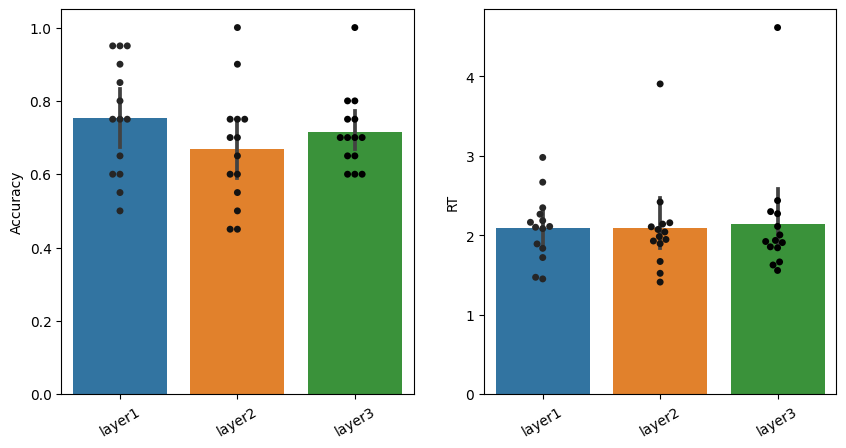

In [23]:
import seaborn as sns

fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(10,5))
sns.barplot(data=final_participants_df[['testing_layer_1_accuracy','testing_layer_2_accuracy','testing_layer_3_accuracy']],ax=axes[0])
sns.swarmplot(data=final_participants_df[['testing_layer_1_accuracy','testing_layer_2_accuracy','testing_layer_3_accuracy']],ax=axes[0],color='k')

axes[0].set_xticklabels(labels=['layer1','layer2','layer3'],rotation=30)
axes[0].set_ylabel('Accuracy')

sns.barplot(data=final_participants_df[['testing_layer_1_rt','testing_layer_2_rt','testing_layer_3_rt']],ax=axes[1])
sns.swarmplot(data=final_participants_df[['testing_layer_1_rt','testing_layer_2_rt','testing_layer_3_rt']],ax=axes[1],color='k')

axes[1].set_xticklabels(labels=['layer1','layer2','layer3'],rotation=30)
axes[1].set_ylabel('RT')


Text(0, 0.5, 'RT')

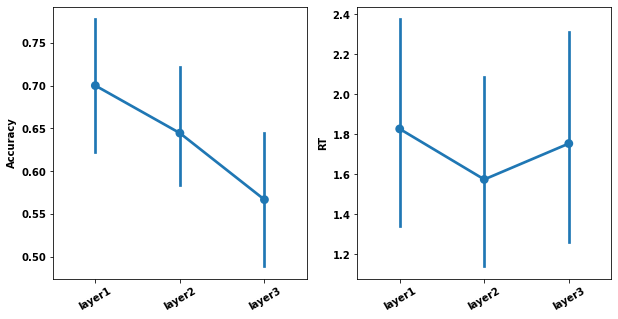

In [30]:
import seaborn as sns

fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(10,5))
sns.pointplot(data=final_participants_df[['testing_layer_1_accuracy','testing_layer_2_accuracy','testing_layer_3_accuracy']],ax=axes[0])
#sns.swarmplot(data=final_participants_df[['testing_layer_1_accuracy','testing_layer_2_accuracy','testing_layer_3_accuracy']],ax=axes[0],color='k')

axes[0].set_xticklabels(labels=['layer1','layer2','layer3'],rotation=30)
axes[0].set_ylabel('Accuracy')

sns.pointplot(data=final_participants_df[['testing_layer_1_rt','testing_layer_2_rt','testing_layer_3_rt']],ax=axes[1])
#sns.swarmplot(data=final_participants_df[['testing_layer_1_rt','testing_layer_2_rt','testing_layer_3_rt']],ax=axes[1],color='k')

axes[1].set_xticklabels(labels=['layer1','layer2','layer3'],rotation=30)
axes[1].set_ylabel('RT')
